In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import mlflow

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [21]:
from lightgbm import LGBMRegressor

In [4]:
TARGET = 'num_sold'
TRACKING_URI = "http://127.0.0.1:8080"
EXPERIMENT_NAME = "kaggle_sales"
SEED = 42

In [5]:
mlflow.set_tracking_uri(TRACKING_URI)
experiment = mlflow.set_experiment(EXPERIMENT_NAME)

# 1. Read the data

In [6]:
df_train = pd.read_csv('../data/processed/train.zip', index_col=0)
print(df_train.shape)
df_train.head()

(83940, 15)


country  store  product  num_sold  year  month  quarter  day  weekday  \
id                                                                          
0         0      1        0        63     0      1        1    1        6   
1         0      1        1        66     0      1        1    1        6   
2         0      1        2         9     0      1        1    1        6   
3         0      1        3        59     0      1        1    1        6   
4         0      1        4        49     0      1        1    1        6   

    dayofyear  time_no  year_sin_1  year_cos_1  year_sin_0.5  year_cos_0.5  
id                                                                          
0           1        0         0.0         1.0           0.0           1.0  
1           1        0         0.0         1.0           0.0           1.0  
2           1        0         0.0         1.0           0.0           1.0  
3           1        0         0.0         1.0           0.0           1.0  
4           1        0         0.0         1.0           0.0           1.0

In [7]:
df_test = pd.read_csv('../data/processed/test.zip', index_col=0)
print(df_test.shape)
df_test.head()

(20985, 15)


country  store  product  num_sold  year  month  quarter  day  weekday  \
id                                                                              
115965        1      1        0       125     4      3        1   27        5   
115966        1      1        1       148     4      3        1   27        5   
115967        1      1        2        22     4      3        1   27        5   
115968        1      1        3       131     4      3        1   27        5   
115969        1      1        4       134     4      3        1   27        5   

        dayofyear  time_no  year_sin_1  year_cos_1  year_sin_0.5  year_cos_0.5  
id                                                                              
115965         86     1546    0.995919    0.090252      0.674444      0.738326  
115966         86     1546    0.995919    0.090252      0.674444      0.738326  
115967         86     1546    0.995919    0.090252      0.674444      0.738326  
115968         86     1546    0.995919    0.090252      0.674444      0.738326  
115969         86     1546    0.995919    0.090252      0.674444      0.738326

In [8]:
X_train, X_test = df_train.copy(), df_test.copy()
y_train, y_test = X_train.pop(TARGET), X_test.pop(TARGET)

# 2. Service functions

In [9]:
def get_date(df):
    return pd.to_datetime(dict(year=df['year']+2017, 
                               month=df['month'], 
                               day=df['day']))

In [10]:
def plot_results(y_pred):
    
    results = df_test.copy()
    results['date'] = get_date(results) # add columns with date
    results['y_pred'] = y_pred

    fig, ax = plt.subplots()

    results.groupby('date')[TARGET].sum().plot(label='actual', ax=ax)
    results.groupby('date')['y_pred'].sum().plot(label='predicted', ax=ax)
    fig.legend();

    return fig

In [16]:
def run_experiment(model, params, run_name):
    
    with mlflow.start_run(run_name=run_name) as run:
        
    
        mlflow.log_params(params)
    
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score_mae = mean_absolute_error(y_test, y_pred)
        score_rmse = root_mean_squared_error(y_test, y_pred)
    
        mlflow.log_metric("MAE", score_mae)
        mlflow.log_metric("RMSE", score_rmse)
        print("MAE", round(score_mae,3)) 
        print("RMSE", round(score_rmse,3)) 
    
        mlflow.sklearn.log_model(sk_model = model,
                                 input_example= X_train.sample(10, random_state=SEED),
                                 artifact_path=f"mlflow/{run_name}/model")
    
        fig = plot_results(y_pred)
        mlflow.log_figure(fig, f"results_of_{run_name}.png")   
    

# 3. RandomForest

In [17]:
params = {
            "n_estimators": 100,
            "max_depth": 10,
            "random_state": SEED
        }

In [18]:
model = RandomForestRegressor(**params)

MAE 16.495
RMSE 31.353


/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`.

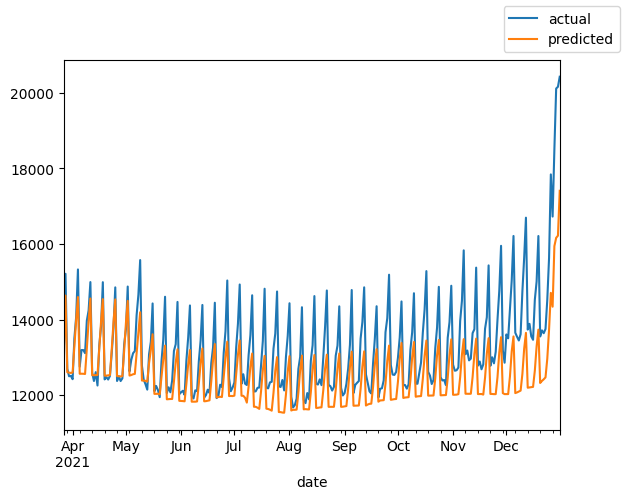

In [19]:
run_experiment(model, params, "RandomForest")

# 4. LinearRegression

MAE 123.909
RMSE 161.96


/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`.

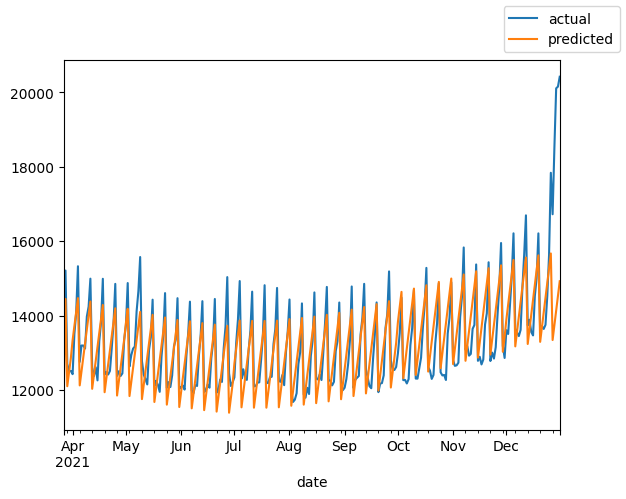

In [20]:
model = LinearRegression()
run_experiment(model, {}, "LinearRegression")

# 5. LightGBM

MAE 11.857
RMSE 22.474


/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/wsl/miniconda3/envs/mlops3/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`.

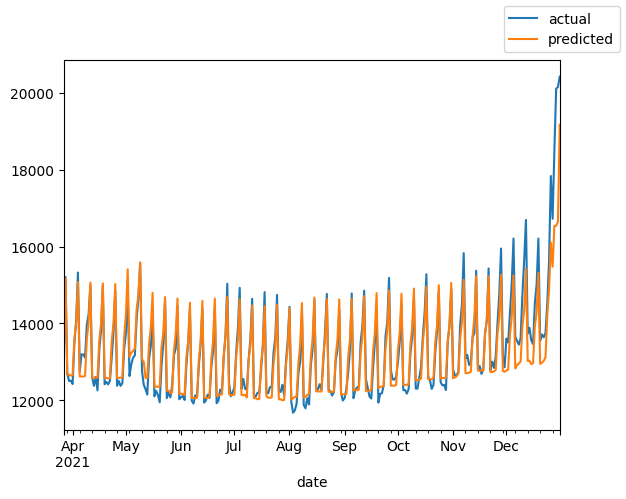

In [24]:
params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'MedianAbsoluteError',
    'objective': 'regression',
    'random_state': SEED,
    'verbosity': -1,
    'device': 'cpu',
}

model = LGBMRegressor(**params)

run_experiment(model, params, "LGBMRegressor")